<a href="https://colab.research.google.com/github/krshrey10/Stock_Price_Prediction_LSTM/blob/main/Stock_Price_Prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Install Required Libraries**

---



In [1]:
!pip install pandas numpy matplotlib yfinance tensorflow scikit-learn

**Import Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math
from sklearn.metrics import mean_squared_error
import joblib

# **Step 2: Load and Prepare Stock Data**

---



**2.1 Download Stock Data (Tesla Example)**

In [3]:
# Download Tesla stock data
ticker = "TSLA"
start_date = "2015-01-01"
end_date = "2023-12-31"

df = yf.download(ticker, start=start_date, end=end_date)
df = df[['Close']]  # We'll predict closing prices
print(df.head())

/tmp/ipython-input-3-4242650852.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price           Close
Ticker           TSLA
Date                 
2015-01-02  14.620667
2015-01-05  14.006000
2015-01-06  14.085333
2015-01-07  14.063333
2015-01-08  14.041333


**2.2 Visualize Historical Prices**

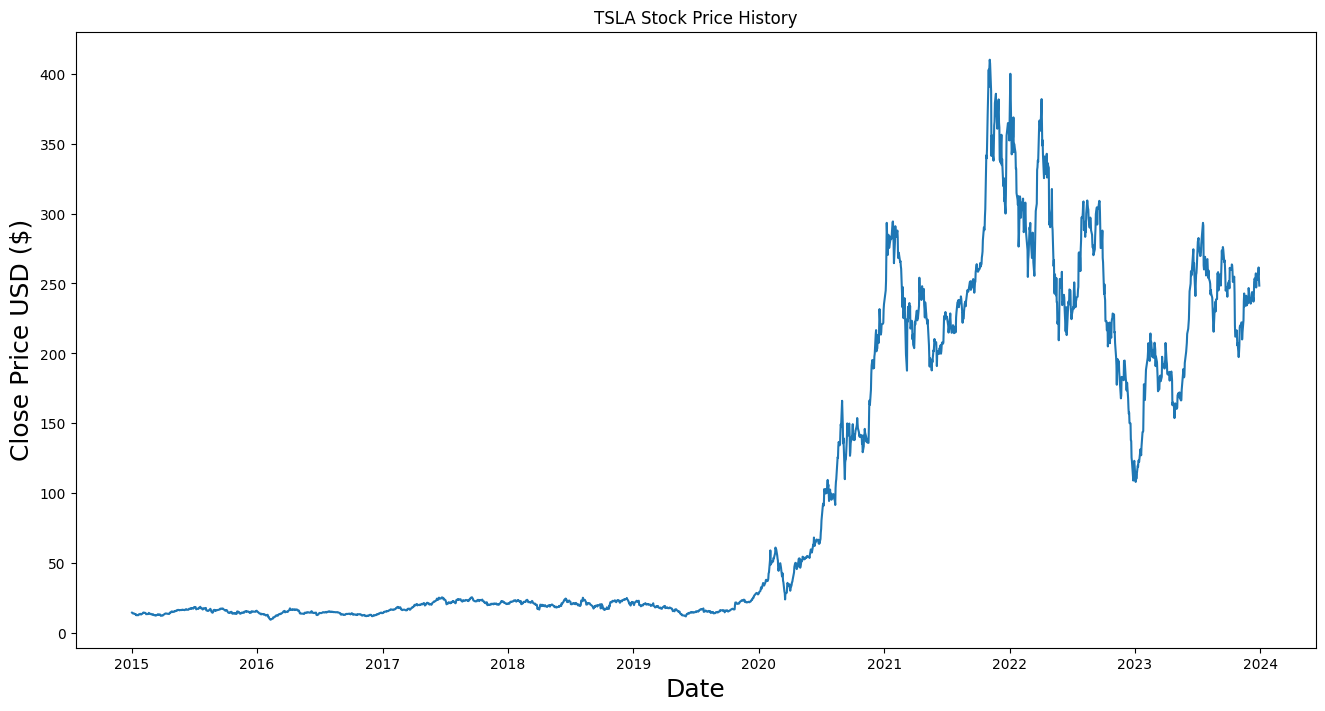

In [4]:
plt.figure(figsize=(16,8))
plt.title(f'{ticker} Stock Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

**2.3 Preprocess Data**

In [5]:
# Scale data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)

# Create training dataset (80% of data)
training_data_len = math.ceil(len(scaled_data) * 0.8)

# Create scaled training data
train_data = scaled_data[0:training_data_len, :]

# Split into X_train and y_train
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)

# Reshape data for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# **Step 3: Build and Train LSTM Model**

---



**3.1 Define LSTM Model**

In [6]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**3.2 Train the Model**

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.0190
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0015
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0016
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0016
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0011
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0012
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0013
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 8.9992e-04
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0011
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 9.2125e-04
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0011
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0010
Epoch 13/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 8.8460e-04
Epoch 14/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 9.2384e-04
Epoch 15/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3

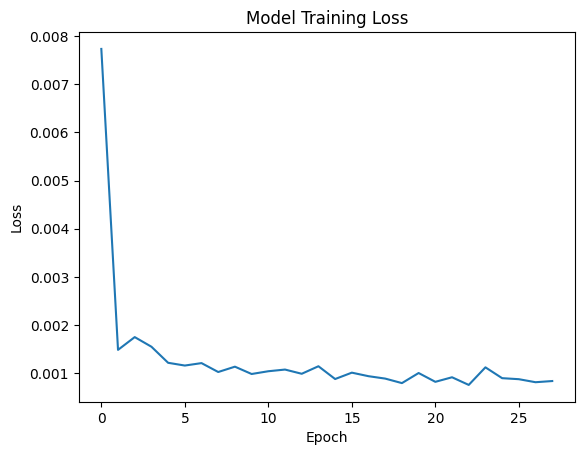

In [7]:
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    callbacks=[early_stop],
    verbose=1
)

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# **Step 4: Evaluate Model Performance**

---



**4.1 Prepare Test Data**

In [8]:
# Create test dataset
test_data = scaled_data[training_data_len - time_step:, :]

# Create X_test and y_test
X_test, y_test = create_dataset(test_data, time_step)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

**4.2 Make Predictions**

In [9]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(df[training_data_len:], predictions))
print(f"Root Mean Squared Error: {rmse}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Root Mean Squared Error: 15.214721898581383


**4.3 Visualize Predictions**

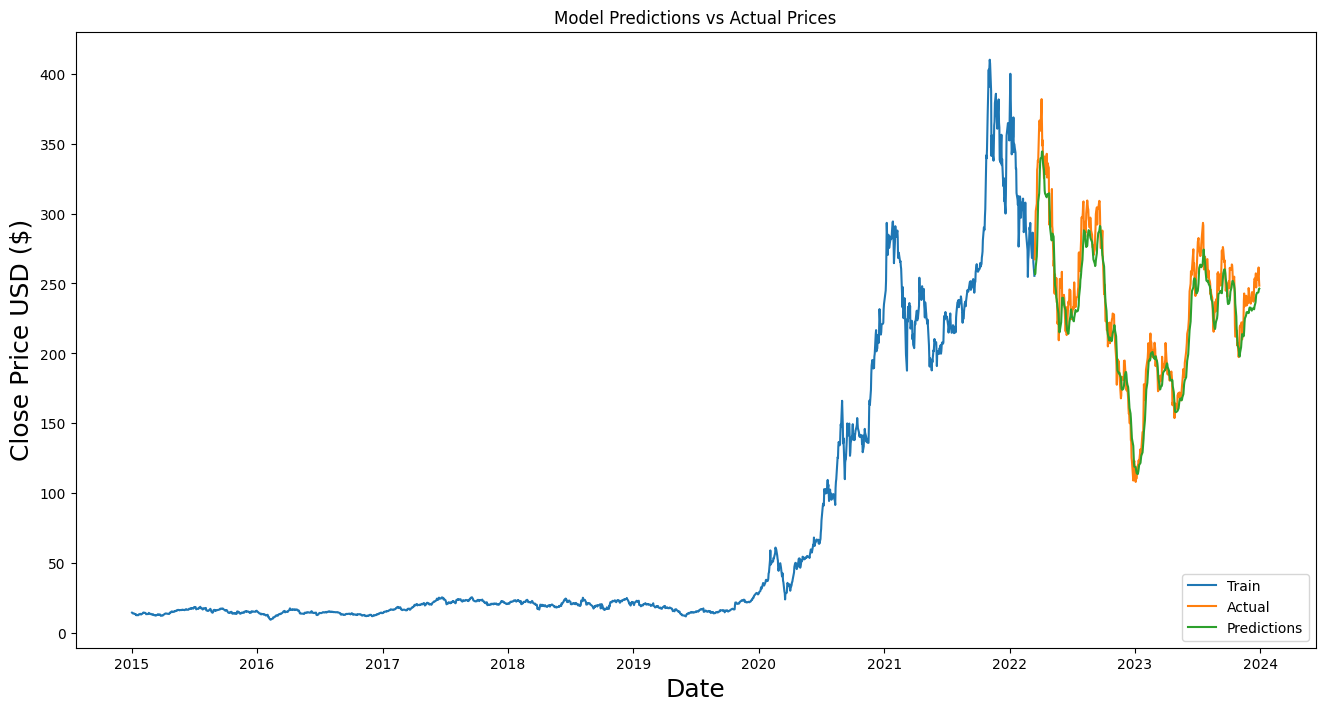

In [10]:
train = df[:training_data_len]
valid = df[training_data_len:].copy()
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model Predictions vs Actual Prices')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()

# **Step 5: Save Model & Create Prediction Function**

---



**5.1 Save the Model**

In [11]:
# Save the entire model
model.save('lstm_stock_predictor.h5')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Save to Google Drive
from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/MyDrive/lstm_stock_predictor.h5')

Mounted at /content/drive


**5.2 Create Prediction Function**

In [12]:
def predict_stock_price(model, scaler, last_60_days):
    # Scale the data
    last_60_days_scaled = scaler.transform(last_60_days)

    # Create dataset
    X_test = []
    X_test.append(last_60_days_scaled)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Get prediction
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    return pred_price[0][0]

# Example usage
last_60_days = df[-60:].values
next_day_pred = predict_stock_price(model, scaler, last_60_days)
print(f"Predicted price for next day: ${next_day_pred:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Predicted price for next day: $244.96
